<a href="https://colab.research.google.com/github/Kitsunnneee/FGAN/blob/main/FGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteLYH3N8/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteLYH3N8/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                     

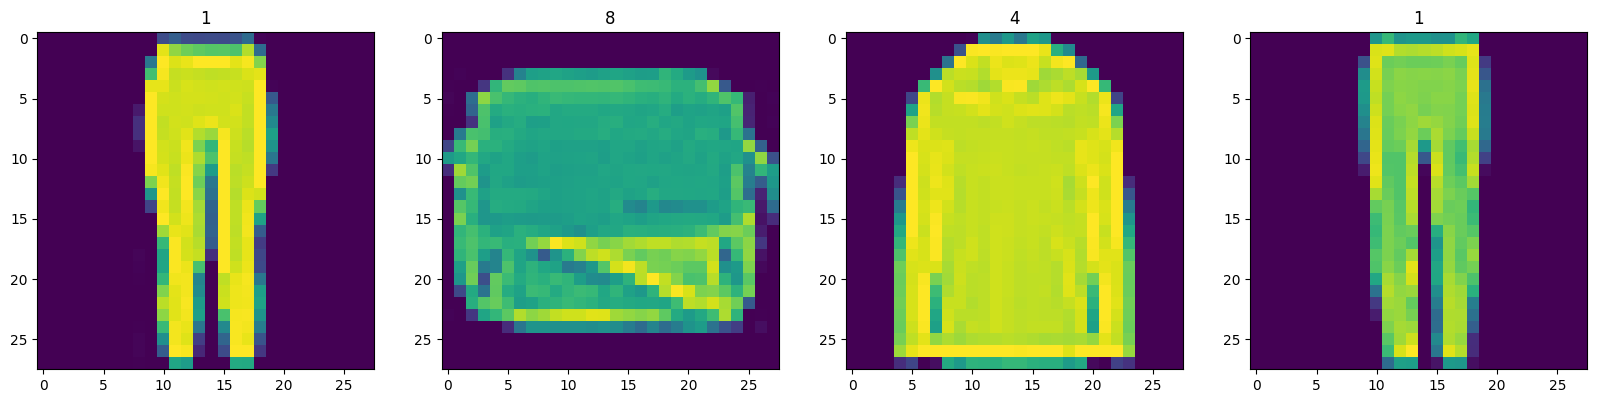

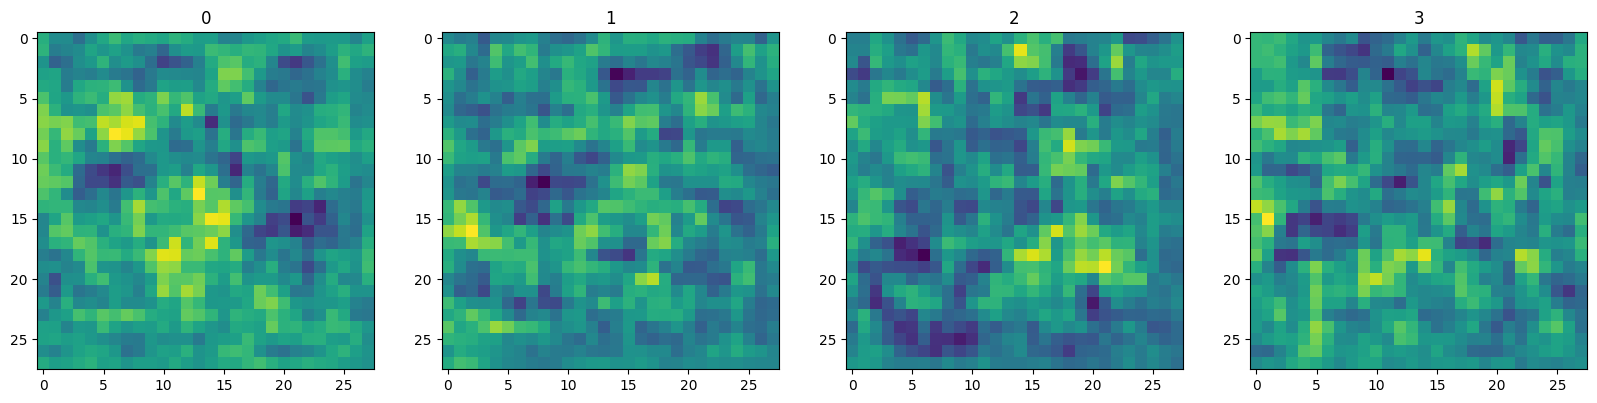

In [6]:

# Brining in tensorflow datasets for fashion mnist 
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')
ds.as_numpy_iterator().next()['label']
# Do some data transformation
import numpy as np
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()
# Getting data out of the pipeline
dataiterator.next()['image']
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)
ds.as_numpy_iterator().next().shape
(128, 28, 28, 1)


# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model
generator = build_generator()
generator.summary()

img = generator.predict(np.random.randn(4,128,1))
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)


def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 
discriminator = build_discriminator()
discriminator.summary()

In [16]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

from tensorflow.keras.models import Model
class FashionGan(Model):
  def __init__(self,generator,discriminator,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.generator = generator
    self.discriminator = discriminator
  def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
    super().compile(*args,**kwargs)

    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss
  def train_step(self, batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)),training = False)
    with tf.GradientTape() as d_tape:
      yhat_real = self.discriminator(real_images, training = True)
      yhat_fake = self.discriminator(fake_images, training = True)
      yhat_realfake = tf.concat([yhat_real,yhat_fake],axis = 0)
      y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis = 0)
      noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real,noise_fake],axis = 0)

      total_d_loss = self.d_loss(y_realfake,yhat_realfake)

    dgrad = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))
      
      
    with tf.GradientTape() as g_tape:

      gen_images = self.generator(tf.random.normal((128,128,1)),training = True)

      predicted_labels = self.discriminator(gen_images,training = False)

      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)


    ggrad = g_tape.gradient(total_g_loss,self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))

    return {"total d_loss":total_d_loss,"total g_loss":total_g_loss}



In [17]:
fashgan = FashionGan(generator,discriminator)

In [18]:
fashgan.compile(g_opt,d_opt,g_loss,d_loss)

In [10]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [19]:
hist = fashgan.fit(ds , epochs = 20)

Epoch 1/20
469/469 [==============================] - 95s 178ms/step - total d_loss: 0.5323 - total g_loss: 1.1432
Epoch 2/20
469/469 [==============================] - 82s 176ms/step - total d_loss: 0.3403 - total g_loss: 4.0133
Epoch 3/20
469/469 [==============================] - 82s 175ms/step - total d_loss: 0.2835 - total g_loss: 5.7012
Epoch 4/20
469/469 [==============================] - 82s 175ms/step - total d_loss: 0.2781 - total g_loss: 5.5762
Epoch 5/20
469/469 [==============================] - 82s 175ms/step - total d_loss: 0.2758 - total g_loss: 5.3752
Epoch 6/20
469/469 [==============================] - 82s 175ms/step - total d_loss: 0.2736 - total g_loss: 5.2045
Epoch 7/20
469/469 [==============================] - 82s 175ms/step - total d_loss: 0.2727 - total g_loss: 4.9984
Epoch 8/20
469/469 [==============================] - 82s 175ms/step - total d_loss: 0.2719 - total g_loss: 4.7798
Epoch 9/20
469/469 [==============================] - 82s 175ms/step - total d_l

1/1 [==============================] - 0s 328ms/step


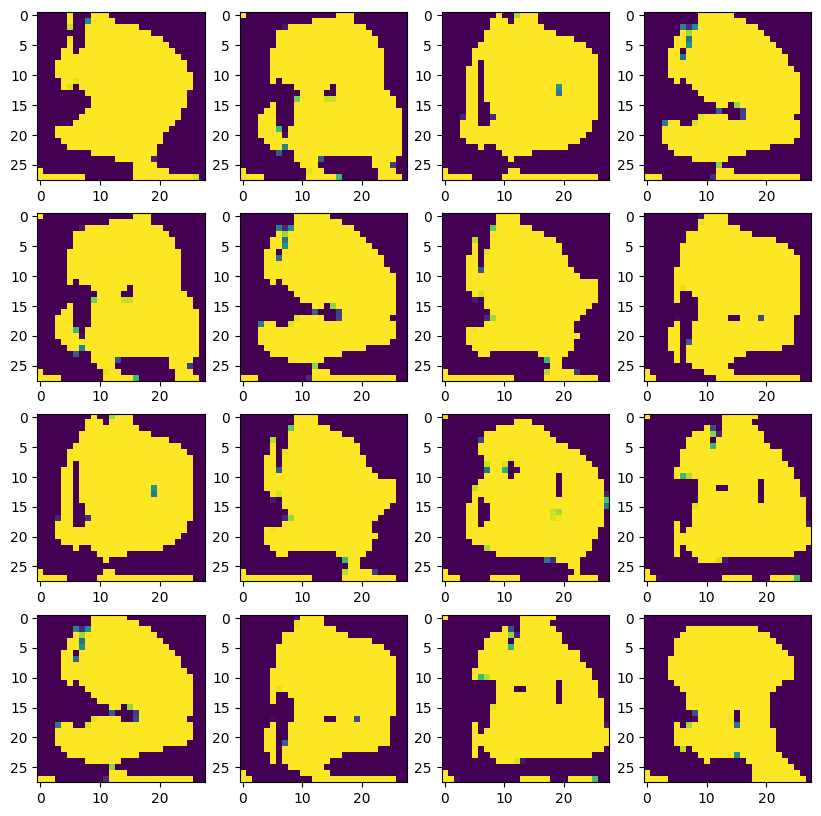

In [22]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])